_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from numpy import array

## Pretraining

The `capa_intermittency.dat` feeds the model with the dynamics of the Capacitor

In [3]:
data = np.genfromtxt('capa_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,0]

## Computing the Gradient

_Calculating the value of_ $\frac{dx}{dt}$

In [4]:
t_diff = 1
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:] # dx/dt
print(gradient_t)

1.0
1        0.000298
2        0.000298
3        0.000297
4        0.000297
5        0.000297
           ...   
9996     0.000018
9997     0.000018
9998     0.000018
9999     0.000018
10000    0.000018
Name: 0, Length: 10000, dtype: float64


## Loading Datasets

In [5]:
data = pd.read_csv("c2_interpolated_1500_100.csv")
training_set = data.iloc[:, 1]
training_set

0       90.500000
1       90.275910
2       90.051821
3       89.827731
4       89.603641
          ...    
1595    67.812021
1596    67.807353
1597    67.802684
1598    67.796032
1599    67.786695
Name: C2, Length: 1600, dtype: float64

In [6]:
test = training_set.tail(100)
test
training_set = training_set.head(1500)
training_set

0       90.500000
1       90.275910
2       90.051821
3       89.827731
4       89.603641
          ...    
1495    68.278875
1496    68.274206
1497    68.269538
1498    68.264869
1499    68.260201
Name: C2, Length: 1500, dtype: float64

In [7]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
print(gradient_t)

0       0.000298
1       0.000298
2       0.000297
3       0.000297
4       0.000297
          ...   
9995    0.000018
9996    0.000018
9997    0.000018
9998    0.000018
9999    0.000018
Name: 0, Length: 10000, dtype: float64


In [8]:
df = pd.concat((training_set, gradient_t), axis=1)
df.columns = ['y_t', 'grad_t']

In [9]:
df

,y_t,grad_t
0,90.500000,0.000298
1,90.275910,0.000298
2,90.051821,0.000297
3,89.827731,0.000297
4,89.603641,0.000297
...,...,...
9995,NaN,0.000018
9996,NaN,0.000018
9997,NaN,0.000018
9998,NaN,0.000018


## Plot of the External Forcing from Chaotic Differential Equation

<Axes: >

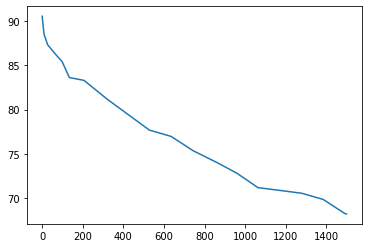

In [10]:
df.iloc[:, 0].plot()

<Axes: >

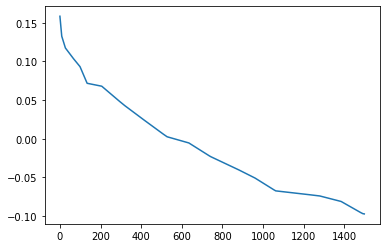

In [11]:
import numpy as np
c0 = 88.1552  # Value for C0
K0 = -0.0026  # Value for K0
K1 = -0.0004  # Value for K1
a = 0.0000    # Value for a
b = 0.0102    # Value for b
c = 2.8734    # Value for c

L = np.minimum(c0, (df.iloc[:, 1] - (df.iloc[:, 0] * (K0 - K1 * (9 * a * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c)**2 + 4 * b * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c) + c)))))
L.plot()

## Preprocessing the data into supervised learning

In [12]:
# split a sequence into samples
def Supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n_in, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n_out)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg

In [13]:
data = Supervised(df.values, n_in = 350, n_out = 100)


cols_to_drop = []
for i in range(2, 351):
    cols_to_drop.extend([f'var2(t-{i})'])

data.drop(cols_to_drop, axis=1, inplace=True)

print(data.head())
print(data.columns)

     var1(t-350)  var1(t-349)  var1(t-348)  var1(t-347)  var1(t-346)  \
350    90.500000    90.275910    90.051821    89.827731    89.603641   
351    90.275910    90.051821    89.827731    89.603641    89.379552   
352    90.051821    89.827731    89.603641    89.379552    89.155462   
353    89.827731    89.603641    89.379552    89.155462    88.931373   
354    89.603641    89.379552    89.155462    88.931373    88.707283   

     var1(t-345)  var1(t-344)  var1(t-343)  var1(t-342)  var1(t-341)  ...  \
350    89.379552    89.155462    88.931373    88.707283    88.494958  ...   
351    89.155462    88.931373    88.707283    88.494958    88.427731  ...   
352    88.931373    88.707283    88.494958    88.427731    88.360504  ...   
353    88.707283    88.494958    88.427731    88.360504    88.293277  ...   
354    88.494958    88.427731    88.360504    88.293277    88.226050  ...   

     var1(t+95)  var2(t+95)  var1(t+96)  var2(t+96)  var1(t+97)  var2(t+97)  \
350   79.071008    0.0002

In [14]:
train = np.array(data[0:len(data)-1])
forecast = np.array(data.tail(1))

In [15]:
trainy = train[:,-300:]
trainX = train[:,:-300]

In [16]:
forecasty = forecast[:,-300:]
forecastX = forecast[:,:-300]

In [17]:
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
forecastX = forecastX.reshape((forecastX.shape[0], 1, forecastX.shape[1]))
print(trainX.shape, trainy.shape, forecastX.shape)

(1050, 1, 251) (1050, 300) (1, 1, 251)


In [18]:
C0 = tf.Variable(88.1552, name="C0", trainable=True, dtype=tf.float32)
K0 = tf.Variable(-0.0026, name="K0", trainable=True, dtype=tf.float32)
K1 = tf.Variable(-0.0004, name="K1", trainable=True, dtype=tf.float32)
a = tf.Variable(0.0000, name="a", trainable=True, dtype=tf.float32)
b = tf.Variable(0.0102, name="b", trainable=True, dtype=tf.float32)
c = tf.Variable(2.8734, name="c", trainable=True, dtype=tf.float32)

splitr = 0.8


def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    #squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    #squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    epsilon = 1e-10
    squared_difference3 = tf.square(
        y_pred[:, 1] - (
            y_pred[:, 0] * (
                K0 - K1 * (
                    9 * a * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c)**2 +
                    4 * b * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c) + c
                )
            )
        )
    )
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(60))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX[:int(splitr*trainX.shape[0])], trainy[:int(splitr*trainX.shape[0])], epochs=500, batch_size=64, validation_data=(trainX[int(splitr*trainX.shape[0]):trainX.shape[0]], trainy[int(splitr*trainX.shape[0]):trainX.shape[0]]), shuffle=False)

Epoch 1/500
14/14 [==============================] - 3s 37ms/step - loss: 5703.7695 - val_loss: 4843.4399
Epoch 2/500
14/14 [==============================] - 0s 4ms/step - loss: 5638.2441 - val_loss: 4797.3374
Epoch 3/500
14/14 [==============================] - 0s 7ms/step - loss: 5588.5029 - val_loss: 4751.4136
Epoch 4/500
14/14 [==============================] - 0s 7ms/step - loss: 5535.9243 - val_loss: 4701.5732
Epoch 5/500
14/14 [==============================] - 0s 6ms/step - loss: 5484.2451 - val_loss: 4654.0576
Epoch 6/500
14/14 [==============================] - 0s 7ms/step - loss: 5433.0649 - val_loss: 4607.0186
Epoch 7/500
14/14 [==============================] - 0s 6ms/step - loss: 5382.3916 - val_loss: 4560.4570
Epoch 8/500
14/14 [==============================] - 0s 6ms/step - loss: 5332.1992 - val_loss: 4514.3340
Epoch 9/500
14/14 [==============================] - 0s 6ms/step - loss: 5268.2529 - val_loss: 4442.0781
Epoch 10/500
14/14 [==============================] - 

In [19]:
forecast_without_mc = forecastX
yhat_without_mc = model.predict(forecast_without_mc) # Step Ahead Prediction
forecast_without_mc = forecast_without_mc.reshape((forecast_without_mc.shape[0], forecast_without_mc.shape[2])) # Historical Input

1/1 [==============================] - 0s 456ms/step


In [20]:
forecastX.shape

(1, 1, 251)

In [21]:
forecast_without_mc.shape

(1, 251)

In [22]:
inv_yhat_without_mc = np.concatenate((forecast_without_mc, yhat_without_mc), axis=1) # Concatenation of predicted values with Historical Data
#inv_yhat_without_mc = scaler.inverse_transform(inv_yhat_without_mc) # Transform labels back to original encoding

In [23]:
inv_yhat_without_mc.shape

(1, 311)

In [24]:
fforecast = inv_yhat_without_mc[:,-300:]

In [25]:
fforecast.shape

(1, 300)

In [26]:
final_forecast = fforecast[:,0:300:3]

In [27]:
fforecast.shape

(1, 300)

In [28]:
# code to replace all negative value with 0
final_forecast[final_forecast<0] = 0

In [29]:
final_forecast

array([[7.12368628e+01, 7.12142484e+01, 7.12052848e+01, 7.11963212e+01,
        7.11873576e+01, 7.11783940e+01, 7.11694304e+01, 7.11604669e+01,
        7.11515033e+01, 7.11425397e+01, 7.11335761e+01, 7.11246125e+01,
        7.11156489e+01, 7.11066853e+01, 7.10977218e+01, 7.10887582e+01,
        7.10797946e+01, 7.10708310e+01, 7.10618674e+01, 7.10529038e+01,
        7.10439402e+01, 7.10349767e+01, 7.10260131e+01, 7.10170495e+01,
        7.10080859e+01, 7.09991223e+01, 7.09901587e+01, 7.09811951e+01,
        7.09722316e+01, 7.09632680e+01, 7.09543044e+01, 7.09453408e+01,
        7.09363772e+01, 7.09274136e+01, 7.09184501e+01, 7.09094865e+01,
        7.09005229e+01, 7.08920868e+01, 7.08836835e+01, 7.08752801e+01,
        7.08668768e+01, 7.08584734e+01, 7.08500700e+01, 7.08416667e+01,
        7.08332633e+01, 7.08248599e+01, 7.08164566e+01, 7.08080532e+01,
        7.07996499e+01, 7.07912465e+01, 7.07828431e+01, 7.07744398e+01,
        7.07660364e+01, 7.07576330e+01, 7.07492297e+01, 7.074082

In [30]:
final_forecast.shape

(1, 100)

In [31]:
test.shape

(100,)

In [32]:
training_set = np.array(training_set)
test = np.array(test)
final_forecast = np.array(final_forecast.squeeze(0))

In [33]:
test

array([68.25553221, 68.25086368, 68.24619514, 68.24152661, 68.23685808,
       68.23218954, 68.22752101, 68.22285247, 68.21818394, 68.21351541,
       68.20884687, 68.20417834, 68.1995098 , 68.19484127, 68.19017274,
       68.1855042 , 68.18083567, 68.17616713, 68.1714986 , 68.16683007,
       68.16216153, 68.157493  , 68.15282446, 68.14815593, 68.14348739,
       68.13881886, 68.13415033, 68.12948179, 68.12481326, 68.12014472,
       68.11547619, 68.11080766, 68.10613912, 68.10147059, 68.09680205,
       68.09213352, 68.08746499, 68.08279645, 68.07812792, 68.07345938,
       68.06879085, 68.06412232, 68.05945378, 68.05478525, 68.05011671,
       68.04544818, 68.04077965, 68.03611111, 68.03144258, 68.02677404,
       68.02210551, 68.01743697, 68.01276844, 68.00809991, 68.00343137,
       67.99876284, 67.9940943 , 67.98942577, 67.98475724, 67.9800887 ,
       67.97542017, 67.97075163, 67.9660831 , 67.96141457, 67.95674603,
       67.9520775 , 67.94740896, 67.94274043, 67.9380719 , 67.93

In [34]:
test.shape

(100,)

In [35]:
final_forecast.shape

(100,)

In [36]:
test.shape

(100,)

In [37]:
import math
MSE = np.square(np.subtract(np.array(test),np.array(final_forecast))).mean()   
rsme = math.sqrt(MSE)
print(rsme)  
MAE = np.abs(np.subtract(np.array(test),np.array(final_forecast))).mean()   
mae = MAE
print(mae)

29.59867219590584
15.172605959988045
